In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [1]:
# Get data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2024-02-01 03:08:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2024-02-01 03:08:46 (10.7 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2024-02-01 03:09:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-01 03:09:22 (79.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Importing time series with pandas

In [4]:
# prompt: read data with pandas

df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', index_col='Date', parse_dates=True)
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
len(df)

2787

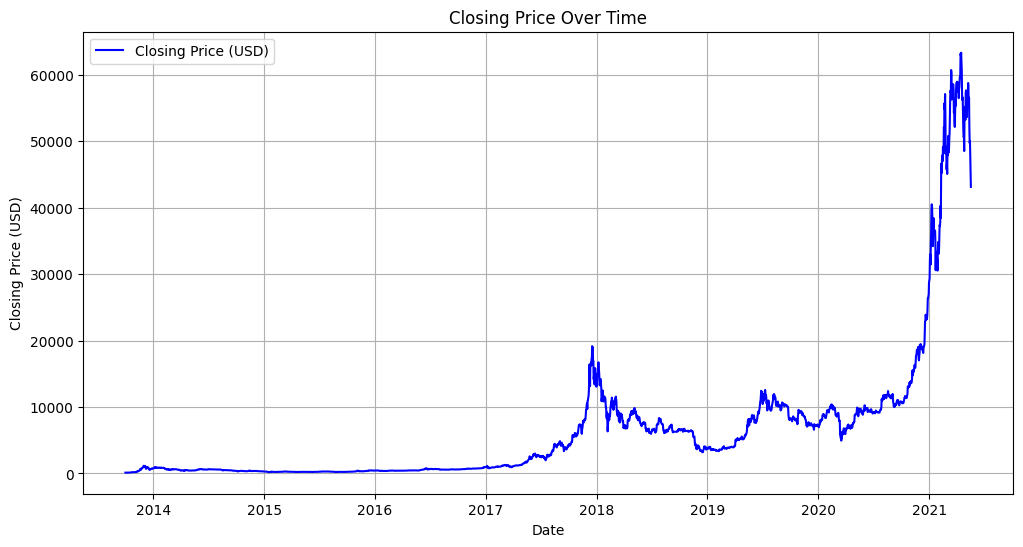

In [9]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Closing Price (USD)'], label='Closing Price (USD)', color='blue')
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


## Format data part 1: Create train and test sets of out time series data

In [10]:
# prompt: create a dataframe with only price and date

bitcoin_prices = df[['Closing Price (USD)']].copy()
bitcoin_prices

,Closing Price (USD)
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [13]:
# prompt: Rename Closing Price (USD) to Price

bitcoin_prices.rename(columns={'Closing Price (USD)': 'Price'}, inplace=True)
bitcoin_prices


,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


In [15]:
timestamps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timestamps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [16]:
# prompt: create train test data with sklearn

from sklearn.model_selection import train_test_split

# Wrong way to make train/test sets for time series data

X_train, X_test, y_train, y_test = train_test_split(timestamps, prices, test_size=0.2, random_state=42, shuffle=False)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (2229,)
y_train shape: (2229,)
X_test shape: (558,)
y_test shape: (558,)


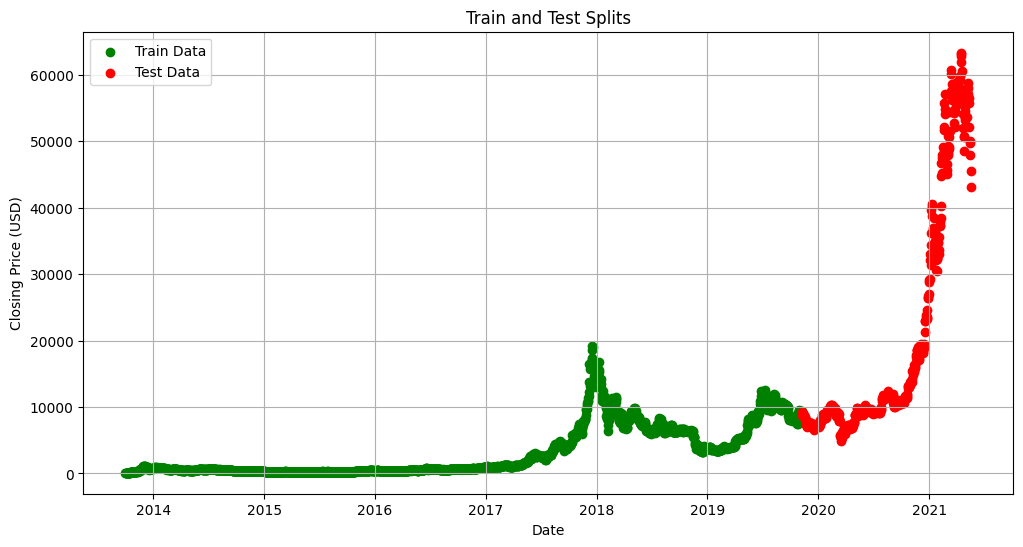

In [21]:
# prompt: plot train and test splits

# Plot train and test splits
plt.figure(figsize=(12, 6))
#plt.plot(timestamps, prices, label='All Data', color='blue')
plt.scatter(X_train, y_train, label='Train Data', color='green')
plt.scatter(X_test, y_test, label='Test Data', color='red')
plt.title('Train and Test Splits')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


prices_train shape: (2229,)
prices_test shape: (558,)


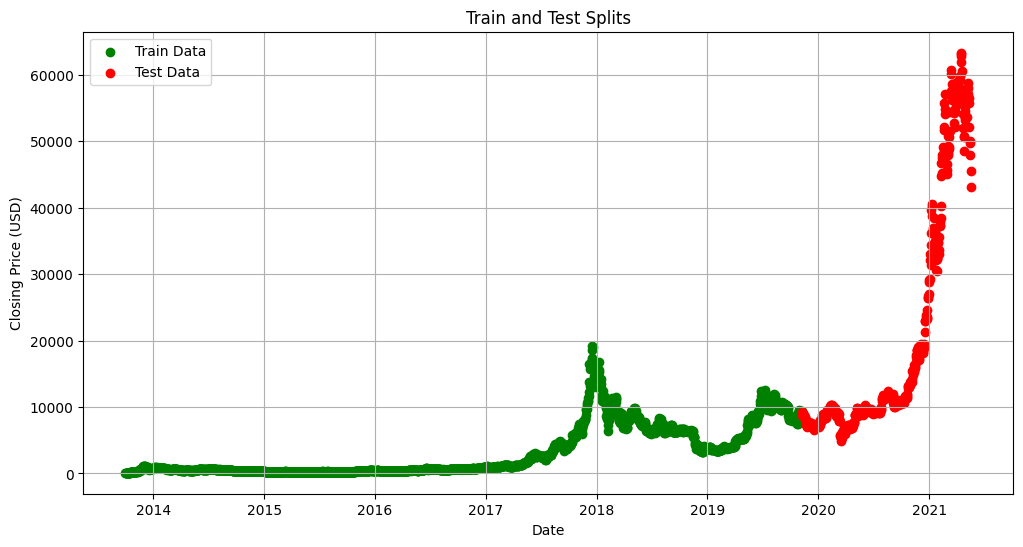

In [22]:
# prompt: create train and test split using indexing

# Correct way to make train/test splits for time series data

split_index = int(0.8 * len(prices))

X_train, y_train = timestamps[:split_index], prices[:split_index]
X_test, y_test = timestamps[split_index:], prices[split_index:]

print(f'prices_train shape: {X_train.shape}')
print(f'prices_test shape: {X_test.shape}')

# Plot train and test splits
plt.figure(figsize=(12, 6))
#plt.plot(timestamps, prices, label='All Data', color='blue')
plt.scatter(X_train, y_train, label='Train Data', color='green')
plt.scatter(X_test, y_test, label='Test Data', color='red')
plt.title('Train and Test Splits')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


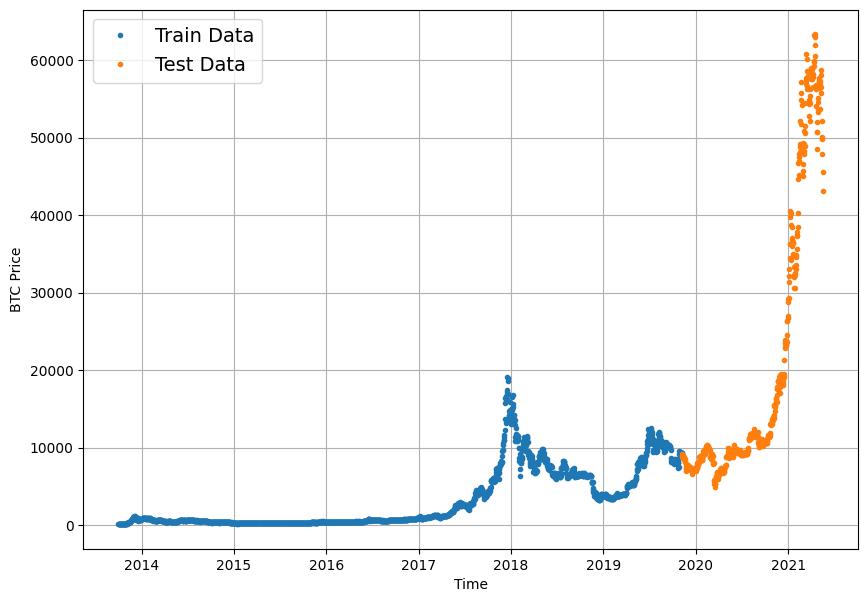

In [29]:
# prompt: create a plotting function

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

# Test plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train Data')
plot_time_series(timesteps=X_test, values=y_test, label='Test Data')